In [1]:
import pandas as pd
import numpy as np
import shared
import json


In [2]:
ve_or_ju = "ju"

In [3]:
runs_df = pd.read_csv(f'data/runs_{ve_or_ju}.tsv', delimiter="\t")


In [4]:
country_counts = runs_df["team_country"].value_counts()
top_country_counts = country_counts[country_counts > 50]
top_countries = top_country_counts.keys().tolist()
display(top_countries)

with open(f"data/top_countries_{ve_or_ju}.json", 'w') as outfile:
    json.dump(top_countries, outfile)

['FIN',
 'SWE',
 'NOR',
 'RUS',
 'LAT',
 'EST',
 'SUI',
 'GBR',
 'LTU',
 'DEN',
 'GER',
 'FRA',
 'ESP',
 'CZE',
 'POL',
 'ITA',
 'USA',
 'UKR',
 'HUN']

In [5]:
runs_df["first_name"] = runs_df.name.str.split(" ", expand=True).iloc[:, 0]
fn_counts = runs_df["first_name"].value_counts()
top_fn_counts = fn_counts[fn_counts > 20]
top_first_names = top_fn_counts.keys().tolist()
display(top_first_names)

with open(f"data/top_first_names_{ve_or_ju}.json", 'w') as outfile:
    json.dump(top_first_names, outfile)

['mikko',
 'antti',
 'timo',
 'juha',
 'matti',
 'jukka',
 'pekka',
 'mika',
 'jari',
 'jussi',
 'janne',
 'ville',
 'hannu',
 'heikki',
 'kari',
 'markku',
 'petri',
 'sami',
 'tuomas',
 'teemu',
 'marko',
 'harri',
 'lauri',
 'markus',
 'ari',
 'pasi',
 'vesa',
 'olli',
 'jouni',
 'jaakko',
 'eero',
 'arto',
 'tero',
 'juho',
 'tommi',
 'kimmo',
 'jani',
 'jarmo',
 'seppo',
 'risto',
 'tomi',
 'ilkka',
 'esa',
 'jarkko',
 'kalle',
 'tuomo',
 'tapio',
 'jyrki',
 'anders',
 'johan',
 'jorma',
 'simo',
 'erkki',
 'erik',
 'toni',
 'juhani',
 'petteri',
 'jouko',
 'jonas',
 'mikael',
 'joonas',
 'henrik',
 'lasse',
 'pertti',
 'aleksi',
 'martin',
 'henri',
 'jan',
 'aki',
 'samuli',
 'niko',
 'andreas',
 'anssi',
 'juuso',
 'esko',
 'pauli',
 'matias',
 'fredrik',
 'paavo',
 'miika',
 'joni',
 'peter',
 'riku',
 'niklas',
 'anton',
 'tapani',
 'daniel',
 'reijo',
 'martti',
 'kai',
 'jarno',
 'raimo',
 'panu',
 'stefan',
 'thomas',
 'keijo',
 'per',
 'magnus',
 'simon',
 'pentti',
 'sak

In [6]:
# Temporarily remove 2018 in order to try predict it in other notebook
runs_df = runs_df[runs_df.year != 2018]
runs_df

,name,year,team_id,team,team_country,pace,leg_nro,num_runs,first_name
1,joni hirvikallio,2017,16,KOOVEE,FIN,5.762,1,6,joni
2,joni hirvikallio,2016,143,KOOVEE,FIN,6.251,6,6,joni
3,joni hirvikallio,2015,12,KOOVEE,FIN,5.843,5,6,joni
4,joni hirvikallio,2013,37,KOOVEE,FIN,5.796,1,6,joni
6,topi anjala,2017,1,KOOVEE,FIN,5.621,1,7,topi
7,topi anjala,2016,9,KOOVEE,FIN,6.100,1,7,topi
8,topi anjala,2015,12,KOOVEE,FIN,5.977,1,7,topi
9,topi anjala,2014,21,KOOVEE,FIN,7.164,2,7,topi
10,topi anjala,2013,37,KOOVEE,FIN,5.642,7,7,topi
11,topi anjala,2012,48,KOOVEE,FIN,5.974,3,7,topi


In [7]:
features = shared.preprocess_features(runs_df, top_countries, top_first_names)
features.head(10)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 64184 entries, 1 to 76530
Data columns (total 9 columns):
name            64184 non-null object
year            64184 non-null int64
team_id         64184 non-null int64
team            64184 non-null object
team_country    63349 non-null object
pace            64184 non-null float64
leg_nro         64184 non-null int64
num_runs        64184 non-null int64
first_name      64184 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 4.9+ MB


None

,team_id,leg_1,leg_2,leg_3,leg_4,leg_5,leg_6,leg_7,c_CZE,c_DEN,...,fn_visa,fn_vladimir,fn_väinö,fn_william,fn_yrjö,fn_öystein,fn_öyvind,team_id_log10,team_id_log100,team_id_square
1,16,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.204120,0.602060,256
2,143,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2.155336,1.077668,20449
3,12,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1.079181,0.539591,144
4,37,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.568202,0.784101,1369
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0.000000,1
7,9,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.954243,0.477121,81
8,12,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.079181,0.539591,144
9,21,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.322219,0.661110,441
10,37,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1.568202,0.784101,1369
11,48,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.681241,0.840621,2304


In [8]:
features.info()

<class 'pandas.core.sparse.frame.SparseDataFrame'>
Int64Index: 64184 entries, 1 to 76530
Columns: 492 entries, team_id to team_id_square
dtypes: Sparse[float64, nan](2), Sparse[int64, nan](2), Sparse[uint8, 0](488)
memory usage: 6.2 MB


In [9]:
x = features.values
#x = features[["team_id", "team_id_log10", "team_id_log100", "team_id_log2", "team_id_square", "leg_id_1", "leg_id_2", "leg_id_3", "leg_id_4", "leg_id_5", "leg_id_6", "leg_id_7"]].values # Poista tää.
y = np.log(runs_df.pace.values)
y = y.reshape(len(y), 1)

display(x.shape)
display(y.shape)

(64184, 492)

(64184, 1)

In [10]:
import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2019)
x_train.shape

(51347, 492)

In [12]:
import matplotlib.pyplot as plt
def fit_and_test_model(model, x_train, x_test, y_train, y_test, fit_params={}):
    model.fit(x_train, y_train.ravel(), **fit_params)
    y_pred = np.exp(model.predict(x_test))
    print(f"Shapes: y_test={np.exp(y_test).shape} y_pred={y_pred.shape}")
    print("Mean squared error: %.3f" % mean_squared_error(np.exp(y_test), y_pred))
    print('Explained variance score: %.3f' % r2_score(np.exp(y_test), y_pred))
    
    plt.scatter(x_test[:,0], np.exp(y_test),  color='red', alpha=0.01)
    plt.scatter(x_test[:,0], y_pred, color='blue', alpha=0.01)
    plt.ylim(4, 20)
    plt.show()

In [13]:
y_train.shape

(51347, 1)

Shapes: y_test=(12837, 1) y_pred=(12837,)
Mean squared error: 5.345
Explained variance score: 0.391


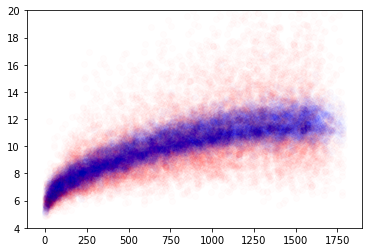

CPU times: user 8.86 s, sys: 1.04 s, total: 9.9 s
Wall time: 3.61 s


In [14]:
%%time
linear = linear_model.LinearRegression()
fit_and_test_model(linear, x_train, x_test, y_train, y_test)

In [15]:
pd.DataFrame({'name':features.keys(), 'coef':linear.coef_})

,name,coef
0,team_id,4.272078e-04
1,leg_1,-6.928412e-02
2,leg_2,-2.188857e-02
3,leg_3,-2.235520e-02
4,leg_4,4.727084e-02
5,leg_5,7.585181e-02
6,leg_6,2.845195e-02
7,leg_7,-3.804671e-02
8,c_CZE,-1.790961e-01
9,c_DEN,-2.589188e-02


      Iter       Train Loss   Remaining Time 
         1           0.0626          138.68m
         2           0.0581          139.24m
         3           0.0545          139.57m
         4           0.0515          138.95m
         5           0.0489          138.44m
         6           0.0469          137.87m
         7           0.0451          137.53m
         8           0.0437          137.70m
         9           0.0424          137.82m
        10           0.0414          137.43m
        20           0.0367          139.09m
        30           0.0354          135.42m
        40           0.0347          135.99m
        50           0.0344          132.53m
        60           0.0342          128.95m
        70           0.0341          126.07m
        80           0.0339          124.03m
        90           0.0338          122.67m
       100           0.0337          121.04m
       200           0.0332          112.86m
       300           0.0328          108.63m
       40

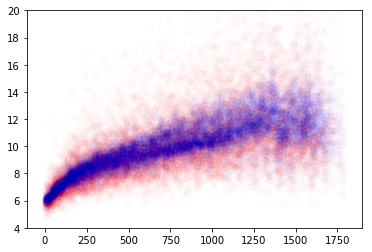

CPU times: user 2h 10min 40s, sys: 10.9 s, total: 2h 10min 51s
Wall time: 2h 10min 57s


In [16]:
%%time
gbr_num_estimators=7100
gbr = sklearn.ensemble.GradientBoostingRegressor(n_estimators=gbr_num_estimators, random_state=0, verbose=1)

fit_and_test_model(gbr, x_train, x_test, y_train, y_test)

#print(f"feature_importances_: {gbr.feature_importances_}")
#gbr_features = pd.DataFrame({'feature':first_names.columns, 'importance': gbr.feature_importances_})
#gbr_features['feature'] = gbr_features['feature'].str.replace('top_first_name_','')
#display(gbr_features.sort_values(by="importance", ascending=False))

In [17]:
gbr_num_estimators_quantile=int(gbr_num_estimators/2)

      Iter       Train Loss   Remaining Time 
         1           0.0567           69.95m
         2           0.0542           69.96m
         3           0.0522           70.50m
         4           0.0506           70.94m
         5           0.0490           71.29m
         6           0.0477           71.42m
         7           0.0466           70.99m
         8           0.0457           71.30m
         9           0.0449           71.66m
        10           0.0442           71.73m
        20           0.0412           71.10m
        30           0.0404           71.48m
        40           0.0400           71.20m
        50           0.0398           70.30m
        60           0.0397           69.48m
        70           0.0396           68.82m
        80           0.0396           68.34m
        90           0.0395           67.69m
       100           0.0395           67.33m
       200           0.0392           64.12m
       300           0.0390           61.47m
       40

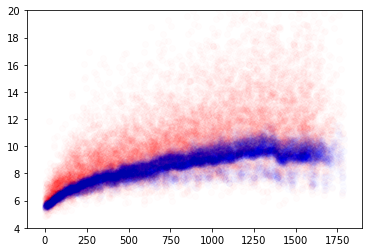

In [18]:
gbr_q_low = sklearn.ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.159, n_estimators=gbr_num_estimators_quantile, random_state=0, verbose=1)
fit_and_test_model(gbr_q_low, x_train, x_test, y_train, y_test)


      Iter       Train Loss   Remaining Time 
         1           0.0642           78.51m
         2           0.0622           79.48m
         3           0.0604           79.31m
         4           0.0589           78.67m
         5           0.0576           78.02m
         6           0.0564           78.23m
         7           0.0554           77.97m
         8           0.0545           77.94m
         9           0.0537           77.51m
        10           0.0530           77.53m
        20           0.0492           77.15m
        30           0.0478           75.33m
        40           0.0472           73.99m
        50           0.0469           73.05m
        60           0.0467           71.97m
        70           0.0466           71.00m
        80           0.0465           70.24m
        90           0.0464           69.60m
       100           0.0463           69.06m
       200           0.0459           64.93m
       300           0.0457           62.15m
       40

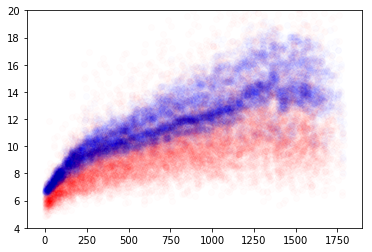

In [19]:
gbr_q_high = sklearn.ensemble.GradientBoostingRegressor(loss='quantile', alpha=0.841, n_estimators=gbr_num_estimators_quantile, random_state=0, verbose=1)
fit_and_test_model(gbr_q_high, x_train, x_test, y_train, y_test)



In [20]:
joblib.dump(gbr, 'gbr.sav')
joblib.dump(gbr_q_low, 'gbr_q_low.sav')
joblib.dump(gbr_q_high, 'gbr_q_high.sav')


['gbr_q_high.sav']

In [21]:
gbr_preds = gbr.predict(pd.DataFrame(x_test))
gbr_q_low_preds = gbr_q_low.predict(pd.DataFrame(x_test))
gbr_q_high_preds = gbr_q_high.predict(pd.DataFrame(x_test))

In [22]:
gbr_q_pred_errors = pd.DataFrame({
    'q_low':np.exp(gbr_q_low_preds),
    'true':np.exp(y_test).ravel(), 
    'predicted':np.exp(gbr_preds), 
    'q_high':np.exp(gbr_q_high_preds), 
})

gbr_q_pred_errors["q_low_error"] = gbr_q_pred_errors.true < gbr_q_pred_errors.q_low
gbr_q_pred_errors["q_high_error"] = gbr_q_pred_errors.true > gbr_q_pred_errors.q_high
gbr_q_pred_errors["q_error"] = np.logical_or(gbr_q_pred_errors.q_low_error, gbr_q_pred_errors.q_high_error)

# Intentionally don't use log scale for calculation to get bigger std 
gbr_q_pred_errors["std"] = (gbr_q_pred_errors.q_high - gbr_q_pred_errors.q_low) / 2
gbr_q_pred_errors["std_correct"] = np.exp((gbr_q_high_preds - gbr_q_low_preds) / 2)
gbr_q_pred_errors["abs_error"] = np.abs(gbr_q_pred_errors.predicted - gbr_q_pred_errors.true)
gbr_q_pred_errors["abs_error_in_stds"] = gbr_q_pred_errors.abs_error / np.exp(gbr_q_pred_errors["std_correct"])

display(gbr_q_pred_errors.tail(15).round(3))
display(gbr_q_pred_errors.q_low_error.mean())
display(gbr_q_pred_errors.q_high_error.mean())
display(gbr_q_pred_errors.q_error.mean())
display(gbr_q_pred_errors["std"].mean())
display(gbr_q_pred_errors["std_correct"].mean())
display(gbr_q_pred_errors["abs_error_in_stds"].mean())

,q_low,true,predicted,q_high,q_low_error,q_high_error,q_error,std,std_correct,abs_error,abs_error_in_stds
12822,8.985,9.839,9.695,11.642,False,False,False,1.328,1.138,0.144,0.046
12823,8.530,9.587,9.907,11.153,False,False,False,1.311,1.143,0.320,0.102
12824,6.749,6.736,7.974,8.701,True,False,True,0.976,1.135,1.238,0.398
12825,8.795,8.877,10.368,12.479,False,False,False,1.842,1.191,1.491,0.453
12826,8.926,9.270,10.654,12.781,False,False,False,1.927,1.197,1.384,0.418
12827,8.638,18.745,12.806,15.670,False,True,True,3.516,1.347,5.939,1.544
12828,7.194,7.286,7.679,9.518,False,False,False,1.162,1.150,0.393,0.124
12829,9.217,9.101,9.252,12.919,True,False,True,1.851,1.184,0.151,0.046
12830,8.649,11.466,10.587,12.095,False,False,False,1.723,1.183,0.879,0.269
12831,7.555,9.353,8.826,10.211,False,False,False,1.328,1.163,0.527,0.165


0.1655371192646257

0.16101892965646178

0.32655604892108747

1.7960157078854717

1.1863481870490475

0.46041760384338554

In [23]:
np.exp(1.350678)

3.860041752005591

In [24]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined

In [ ]:
import os
#os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'
#os.environ['THEANO_FLAGS'] = 'device=cuda,floatX=float32,force_device=True'

import pymc3 as pm
import pmlearn
from pmlearn.linear_model import LinearRegression
print('Running on pymc-learn v{}'.format(pmlearn.__version__))


In [ ]:
import multiprocessing
multiprocessing.cpu_count()

In [ ]:

pmlearn_linear = LinearRegression()
fit_params={
    "inference_type": "nuts",
    "inference_args": {
        "cores": multiprocessing.cpu_count() -1,
        #"chains":2,
        "init": 'adapt_diag',
        #"tune": 2000,
        "target_accept": 0.9999
    }
}
fit_and_test_model(pmlearn_linear, pd.DataFrame(data=x_train), pd.DataFrame(x_test), y_train, y_test,fit_params)

In [ ]:
pmlearn_preds = pmlearn_linear.predict(pd.DataFrame(x_test), return_std=True)

In [ ]:

joblib.dump(pmlearn_linear, 'pmlearn_linear.sav')

In [ ]:
pred_errors = pd.DataFrame({
    'mean':np.exp(pmlearn_preds[0]), 
    'std':np.exp(pmlearn_preds[1]), 
    'true':np.exp(y_test).ravel(), 
    'error':np.abs(np.exp(y_test).ravel() -np.exp(pmlearn_preds[0])) / np.exp(pmlearn_preds[1])
})
display(pred_errors.head(15))
pred_errors.error.mean()

In [ ]:
pmlearn_linear.plot_elbo()

In [ ]:
pm.traceplot(pmlearn_linear.trace)

In [ ]:
pm.forestplot(pmlearn_linear.trace, varnames=["betas", "alpha", "s"]);

In [ ]:
summary_df = pm.summary(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])
summary_df

In [ ]:
pm.plot_posterior(pmlearn_linear.trace, varnames=["betas", "alpha", "s"],
                 figsize = [14, 8])

In [ ]:
pm.gelman_rubin(pmlearn_linear.trace, varnames=["betas", "alpha", "s"])